In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
# from model.vae import aligned_vae, vae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import torch.optim as optim

import diffusion_dist as diff
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

from model.gae import gnn_vae, aligned_gvae, aligned_gae, GraphConvolutionSage

from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt


from model.loss import aligned_gae_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# atac_dataset_diffmap = graphdata('./data/expr_atac_processed.csv', k = 40,  diff = "diffmap")
# rna_dataset_diffmap = graphdata('./data/expr_rna_processed.csv', k = 40, diff="diffmap")
# torch.save(atac_dataset_diffmap, f= "./data/atac_diffmap.pt")
# torch.save(rna_dataset_diffmap, f = "./data/rna_diffmap.pt")

atac_dataset_diffmap = torch.load(f = "./data/atac_diffmap.pt")
rna_dataset_diffmap = torch.load(f = "./data/rna_diffmap.pt")

In [3]:
# atac_dataset_dpt = graphdata('./data/expr_atac_processed.csv', k = 40,  diff = "dpt")
# rna_dataset_dpt = graphdata('./data/expr_rna_processed.csv', k = 40, diff="dpt")
# torch.save(atac_dataset_dpt, f = "./data/atac_dpt.pt")
# torch.save(rna_dataset_dpt, f = "./data/rna_dpt.pt")

atac_dataset_dpt = torch.load(f = "./data/atac_dpt.pt")
rna_dataset_dpt = torch.load(f = "./data/rna_dpt.pt")

In [4]:
# atac_dataset_dpt = testgraphdata(None, 10)
# rna_dataset_dpt = testgraphdata(None, 10)

In [5]:
def mse_loss(latent1, latent2, adj1, adj2, recon_adj1, recon_adj2, lamb_align = 0.01):

    loss_align = lamb_align * torch.norm(latent1 - latent2, p = 'fro')
    
    
    adj1 = adj1 ** 2
    adj2 = adj2 ** 2
    adj1 = (adj1 / torch.norm(adj1, p = 'fro')) 
    adj2 = (adj2 / torch.norm(adj2, p = 'fro')) 
    recon_adj1 = (recon_adj1 / torch.norm(recon_adj1, p = "fro"))
    recon_adj2 = (recon_adj2 / torch.norm(recon_adj2, p = "fro")) 

    # mse approx, mse loss change sqrt with mean from norm loss, same
#     similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro") ** 2 / (adj1.shape[0] ** 2)
#     similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro") ** 2 / (adj2.shape[0] ** 2)
#     similarity_loss1_2 = F.mse_loss(adj1.reshape(1,-1), recon_adj1.reshape(1,-1), reduce="mean")
#     similarity_loss2_2 = F.mse_loss(adj2.reshape(1,-1), recon_adj2.reshape(1,-1), reduce="mean")
    
    similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro")
    similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro")
    
    loss = loss_align + similarity_loss1 + similarity_loss2 
    
    return loss, loss_align, similarity_loss1,  similarity_loss2

In [6]:
# use distance matrix

gae = aligned_gae(feature1_dim = rna_dataset_dpt['X'].shape[1], 
                  feature2_dim = atac_dataset_dpt['X'].shape[1], 
                  hidden_dim1 = 512, hidden_dim2 = 128, hidden_dim3 = 32, 
                  hidden_dim4 = 8, hidden_dim5 = 2,  dropout = 0.)

# optimizer = optim.Adam(gae.parameters(), lr=1e-4, weight_decay=0.01)

optimizer = torch.optim.Adam(params=gae.parameters(), lr=1e-4, weight_decay=0.01)

# decayRate = 0.95
# lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

gae.train()
gae.reset_parameters()

In [7]:
for epoch in range(0, 2000):

    optimizer.zero_grad()

    dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                       rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

    loss, loss_align, loss_dist_atac,  loss_dist_rna = aligned_gae_loss(latent1 = latent_rna, 
                                                                        latent2 = latent_atac, 
                                                                        adj1 = rna_dataset_dpt['adj'], 
                                                                        adj2 = atac_dataset_dpt['adj'], 
                                                                        recon_adj1 = dist_rna, 
                                                                        recon_adj2 = dist_atac, 
                                                                        lamb_align = 0.01,
                                                                        lamb_sim = 10,
                                                                        dist_loss_type = "pearson")
    loss.backward()
    
    optimizer.step()

    # learning rate decay
    # lr_decay.step()

    if epoch % 10 == 0 or epoch == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, loss align {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, loss_align, loss_dist_atac, loss_dist_rna))
        
        
    
    

Epoch: 000, Total loss: 0.30328, loss align 0.20388, Dist RNA loss 0.12603, Dist ATAC loss -0.02663
Epoch: 010, Total loss: -0.85081, loss align 0.06781, Dist RNA loss -0.10785, Dist ATAC loss -0.81077
Epoch: 020, Total loss: -1.10300, loss align 0.06382, Dist RNA loss -0.23533, Dist ATAC loss -0.93149
Epoch: 030, Total loss: -1.24730, loss align 0.06079, Dist RNA loss -0.32558, Dist ATAC loss -0.98251
Epoch: 040, Total loss: -1.34886, loss align 0.05643, Dist RNA loss -0.39470, Dist ATAC loss -1.01059
Epoch: 050, Total loss: -1.42444, loss align 0.05185, Dist RNA loss -0.44294, Dist ATAC loss -1.03335
Epoch: 060, Total loss: -1.48432, loss align 0.04747, Dist RNA loss -0.47687, Dist ATAC loss -1.05491
Epoch: 070, Total loss: -1.53469, loss align 0.04296, Dist RNA loss -0.50361, Dist ATAC loss -1.07403
Epoch: 080, Total loss: -1.57545, loss align 0.03903, Dist RNA loss -0.52425, Dist ATAC loss -1.09023
Epoch: 090, Total loss: -1.60672, loss align 0.03551, Dist RNA loss -0.53973, Dist A

KeyboardInterrupt: 

In [21]:
torch.save(gae.state_dict(), "gae_best.pth")

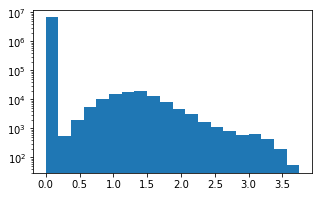

In [8]:
matrix = atac_dataset_dpt['adj'].numpy()
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot()
vals = matrix.reshape(1, matrix.shape[0] * matrix.shape[1]).squeeze()
ax.hist(vals, bins = 20)
plt.yscale("log")

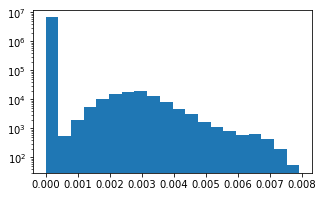

In [9]:
matrix = (atac_dataset_dpt['adj']/torch.norm(atac_dataset_dpt['adj'], p = 'fro')).numpy()
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot()
vals = matrix.reshape(1, matrix.shape[0] * matrix.shape[1]).squeeze()
ax.hist(vals, bins = 20)
plt.yscale("log")

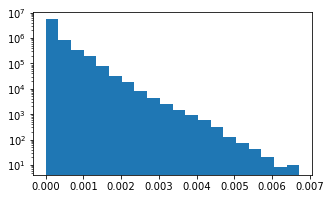

In [10]:
matrix = dist_atac.detach().numpy()
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot()
vals = matrix.reshape(1, matrix.shape[0] * matrix.shape[1]).squeeze()
ax.hist(vals, bins = 20)
plt.yscale("log")

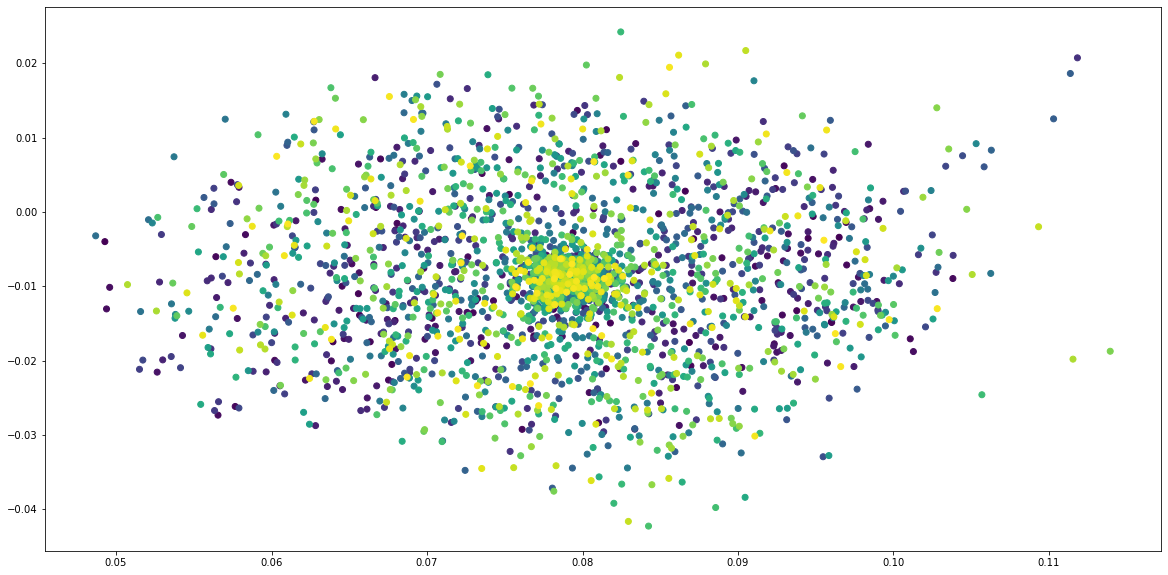

In [11]:
gae.eval()
dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                   rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

z1 = latent_rna.detach().cpu().numpy()
z2 = latent_atac.detach().cpu().numpy()

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z1[:,0], z1[:,1], c = np.arange(rna_dataset_diffmap['X'].shape[0]))